In [0]:
# Installs
!pip install -q kaggle
!pip install pandas-profiling
!pip install pyro-ppl

In [5]:
# Upload kaggle.json and tools.py
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json
Saving tools.py to tools.py


In [6]:
# Imports and set-up
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
import torch
import pyro
import pyro.distributions as dist

from IPython.core.display import display, HTML
from pandas_profiling import ProfileReport
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from tools import *

# Fix random generator seed (for reproducibility of results)
np.random.seed(123)

# Matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permissions change to avoid Kaggle tool startup warning
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle API
!kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 82.5MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 84.1MB/s]
 92% 153M/167M [00:03<00:00, 37.2MB/s]
100% 167M/167M [00:03<00:00, 48.3MB/s]
 89% 106M/120M [00:03<00:00, 26.9MB/s] 
100% 120M/120M [00:03<00:00, 39.6MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 46.3MB/s]
 91% 80.0M/88.4M [00:02<00:00, 31.7MB/s]
100% 88.4M/88.4M [00:02<00:00, 42.7MB/s]


In [0]:
# Functions
@logger
def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

# Initialization

In [8]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv('building_metadata.csv')
df_raw = pd.read_csv('train.csv.zip')
df_weather_raw = pd.read_csv('weather_train.csv.zip')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 3)
to_datetime took 0:00:00 secs, shape(12060910, 3)
start_pipeline took 0:00:00 secs, shape(1449, 6)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
reduce_mem_usage took 0:00:00 secs, shape(1449, 6)
start_pipeline took 0:00:00 secs, shape(139773, 9)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(139773, 9)
to_datetime took 0:00:00 secs, shape(139773, 9)


In [0]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

# Descriptive statistics

In [8]:
# Generate descriptive statistics reports
# If it doesn't work try uninstalling pandas-profiling, re-install it, and restart runtime
profile_meta = ProfileReport(df_meta,
                             title='Building info',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_data = ProfileReport(df,
                             title='Electricity consumption in households',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_weather = ProfileReport(df_weather,
                                title='Weather',
                                minimal=True,
                                html={'style':{'full_width':True}})

# Export reports
# profile_meta.to_file(output_file="info.html")
# profile_weather.to_file(output_file="weather.html")
# profile_data.to_file(output_file="data.html")
# files.download('info.html')
# files.download('weather.html')
# files.download('data.html')

/usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


In [9]:
profile_meta.to_widgets()

In [10]:
profile_weather.to_widgets()

In [11]:
profile_data.to_widgets()

In [0]:
# Join datasets
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
                                    on=['site_id', 'timestamp'],
                                    how='left')

#Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
                      'cloud_coverage',
                      'precip_depth_1_hr',
                      'wind_direction'])

In [0]:
# Convert to categorical types
# df = df.astype({"building_id":'category', "site_id":'category', "year_built":'category'})

In [25]:
pd.set_option('float_format', '{:.1f}'.format)
df.describe()
# print(df.describe().to_latex(index=False))

\begin{tabular}{rrrrrrrrr}
\toprule
 building\_id &  meter\_reading &   site\_id &  square\_feet &  year\_built &  air\_temperature &  dew\_temperature &  sea\_level\_pressure &  wind\_speed \\
\midrule
   1229082.0 &      1229082.0 & 1229082.0 &    1229082.0 &    695561.0 &        1219932.0 &        1219772.0 &           1183642.0 &   1216778.0 \\
       704.9 &          108.6 &       6.9 &      86018.8 &         nan &              nan &              nan &                 nan &         nan \\
       510.5 &          141.5 &       5.7 &      95665.8 &         nan &              0.0 &              0.0 &                 nan &         0.0 \\
         6.0 &            0.0 &       0.0 &       2000.0 &      1900.0 &            -28.9 &            -31.7 &               973.5 &         0.0 \\
       134.0 &           21.0 &       1.0 &      37100.0 &      1956.0 &             10.0 &              1.7 &              1012.5 &         2.1 \\
       773.0 &           58.8 &       6.0 &      57334.0 

In [27]:
df.isna().sum()
(df.isna().sum()/df.shape[0])*100

building_id           0.0
meter_reading         0.0
site_id               0.0
square_feet           0.0
year_built           43.4
air_temperature       0.7
dew_temperature       0.8
sea_level_pressure    3.7
wind_speed            1.0
dtype: float64

# Data Visualization

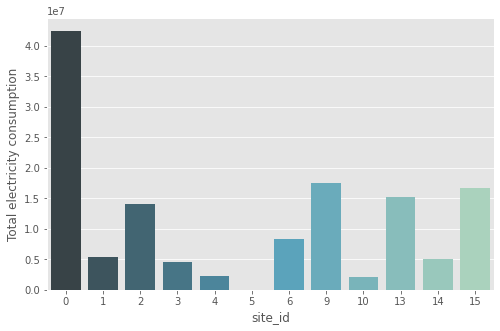

In [21]:
# Site ID vs consumption
plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.groupby('site_id').sum().index, 
            y=df.groupby('site_id').sum().meter_reading,
            palette="GnBu_d")
ax.set(ylabel='Total electricity consumption')
fig = ax.get_figure()
fig.savefig('consumption_site.png')
# files.download("consumption_site.png")

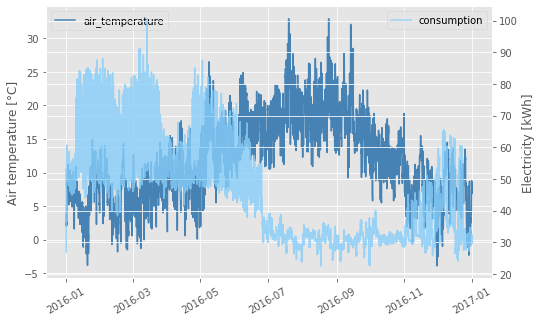

In [22]:
# Consumption vs air temperature
id_to_plot = 135

sample = df[df['building_id'] == id_to_plot]  # same train sample as above

fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

dates = sample.index
ax2.plot_date(dates, 
              sample['meter_reading'], 
              '-', 
              color='lightskyblue', 
              label='consumption', 
              alpha=0.8)
ax.plot_date(dates, 
             sample['air_temperature'], 
             '-', 
             color='steelblue', 
             label='air_temperature')
ax.set_ylabel('Air temperature [°C]'); ax2.set_ylabel('Electricity [kWh]')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
fig.savefig('id_135.png')
# files.download("id_135.png")

# Linear Regression

## Feature selection

We extracted the day of the week and week features from the timestamp. Intuitively power consumption should change in households during weekends, and for example vacation weeks. We one hot encode these features as well as the site_id feature. We scaled the rest of the features by subtracting the mean and dividing by the standard deviation.

In [0]:
# Sample from DataFrame
df_test = df.dropna(axis=0)
df_small = df_test.sample(frac=0.1)
df_small['week'] = df_small.index.week
df_small['day'] =  df_small.index.weekday

In [0]:
# Prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df_small[x]) for x in ["week", "day"]], axis=1)
X_site_id = pd.get_dummies(df_small.site_id)
X_rest = df_small.drop(columns=['meter_reading', 'site_id', 'week', 'day'])

# Scale X_rest
X_rest -= X_rest.mean()
X_rest /= X_rest.std()

In [54]:
# Join matrices
X = np.concatenate([X_time, X_site_id, X_rest], axis=1)
print(X.shape)

(43239, 73)


In [0]:
# Transform target variable
y = df_small.meter_reading.values
mean = y.mean()
std = y.std()
y = (y- mean)/std

## Baseline Model

In [0]:
# Imports
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [0]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [57]:
# Fit ridge linear regression model from train datasets
lr = Ridge()
lr.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [0]:
# Obtain estimations
y_hat = lr.predict(X_test)

# Convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

In [59]:
# Compute errors
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.708
MAE: 91.001
RMSE: 115.663
R2: 0.501


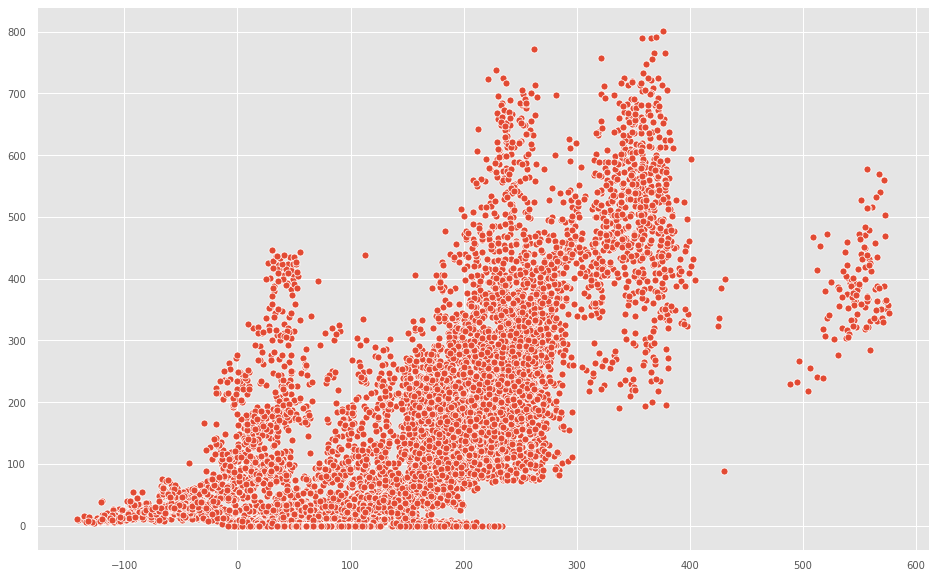

In [60]:
# Plot predictions vs. true value
sns.scatterplot(preds, y_true)

# Bayesian Linear Regression

In [0]:
# Functions
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 5.)) # Prior for the bias/intercept
    beta  = pyro.sample("beta", 
                        dist.Normal(torch.zeros(X.shape[1]),
                                    5.*torch.ones(X.shape[1]))) # Priors for the reg coefs
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.)) # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [0]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [0]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [64]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 108640.2
[100] ELBO: 101081.4
[200] ELBO: 101556.4
[300] ELBO: 109543.8
[400] ELBO: 101075.2
[500] ELBO: 95462.4
[600] ELBO: 94957.2
[700] ELBO: 88810.0
[800] ELBO: 80369.8
[900] ELBO: 88291.1
[1000] ELBO: 81715.4
[1100] ELBO: 84885.2
[1200] ELBO: 84343.6
[1300] ELBO: 81750.8
[1400] ELBO: 74530.1
[1500] ELBO: 83104.0
[1600] ELBO: 74229.5
[1700] ELBO: 80651.2
[1800] ELBO: 73330.1
[1900] ELBO: 53126.7
[2000] ELBO: 74124.9
[2100] ELBO: 58737.7
[2200] ELBO: 69810.2
[2300] ELBO: 56185.5
[2400] ELBO: 54263.9
[2500] ELBO: 56616.4
[2600] ELBO: 65639.6
[2700] ELBO: 44882.6
[2800] ELBO: 51157.2
[2900] ELBO: 57030.6
[3000] ELBO: 41763.4
[3100] ELBO: 41025.9
[3200] ELBO: 48633.7
[3300] ELBO: 47827.9
[3400] ELBO: 46129.2
[3500] ELBO: 39468.9
[3600] ELBO: 41402.6
[3700] ELBO: 39969.8
[3800] ELBO: 41037.1
[3900] ELBO: 38870.7


In [0]:
from pyro.infer import Predictive

# Use predictive from pyro
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [66]:
# Get samples and estimates
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples.T), axis=1)

# Convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

# Compute measures
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.673
MAE: 94.794
RMSE: 121.481
R2: 0.450


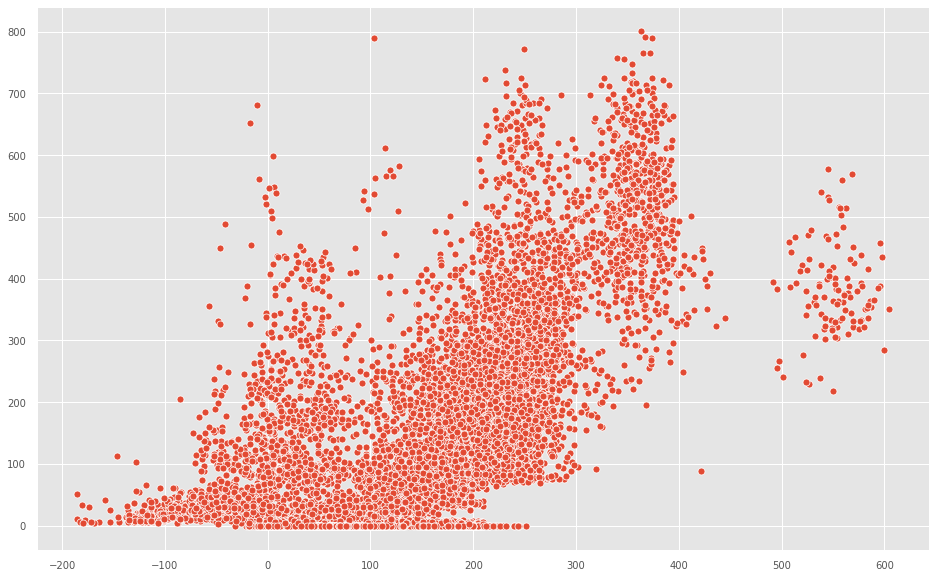

In [67]:
# Plot predictions vs. true value
sns.scatterplot(preds, y_true)